<a href="https://www.kaggle.com/code/pragyamukherjee/alzheimer-s-k-means?scriptVersionId=112859595" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("../input/mri-and-alzheimers/oasis_cross-sectional.csv")

In [3]:
data.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [4]:
data.Hand.unique()

array(['R'], dtype=object)

In [5]:
data.drop(["ID","Hand","Delay"],axis=1,inplace=True)

In [6]:
data.columns=["gender","age","education","soc_eco_st","mini_mental_state_exam","clinical_dementia_rating",
           "estimated_total_intracranial_volume","normalize_whole_brain_volume","atlas_scaling_factor"]

In [7]:
data.gender = [1 if each == "F" else 0 for each in  data.gender]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 9 columns):
gender                                 436 non-null int64
age                                    436 non-null int64
education                              235 non-null float64
soc_eco_st                             216 non-null float64
mini_mental_state_exam                 235 non-null float64
clinical_dementia_rating               235 non-null float64
estimated_total_intracranial_volume    436 non-null int64
normalize_whole_brain_volume           436 non-null float64
atlas_scaling_factor                   436 non-null float64
dtypes: float64(6), int64(3)
memory usage: 30.8 KB


In [9]:
data.isnull().sum()

gender                                   0
age                                      0
education                              201
soc_eco_st                             220
mini_mental_state_exam                 201
clinical_dementia_rating               201
estimated_total_intracranial_volume      0
normalize_whole_brain_volume             0
atlas_scaling_factor                     0
dtype: int64

In [10]:
data.describe()

,gender,age,education,soc_eco_st,mini_mental_state_exam,clinical_dementia_rating,estimated_total_intracranial_volume,normalize_whole_brain_volume,atlas_scaling_factor
count,436.000000,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000
mean,0.614679,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894
std,0.487230,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682
min,0.000000,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000
25%,0.000000,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750
50%,1.000000,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000
75%,1.000000,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250
max,1.000000,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000


In [11]:
def impute_median(series):
    return series.fillna(series.median())

In [12]:
data.education =data["education"].transform(impute_median)
data.soc_eco_st =data["soc_eco_st"].transform(impute_median)
data.mini_mental_state_exam =data["mini_mental_state_exam"].transform(impute_median)
data.clinical_dementia_rating =data["clinical_dementia_rating"].transform(impute_median)

In [13]:
data.head()

,gender,age,education,soc_eco_st,mini_mental_state_exam,clinical_dementia_rating,estimated_total_intracranial_volume,normalize_whole_brain_volume,atlas_scaling_factor
0,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


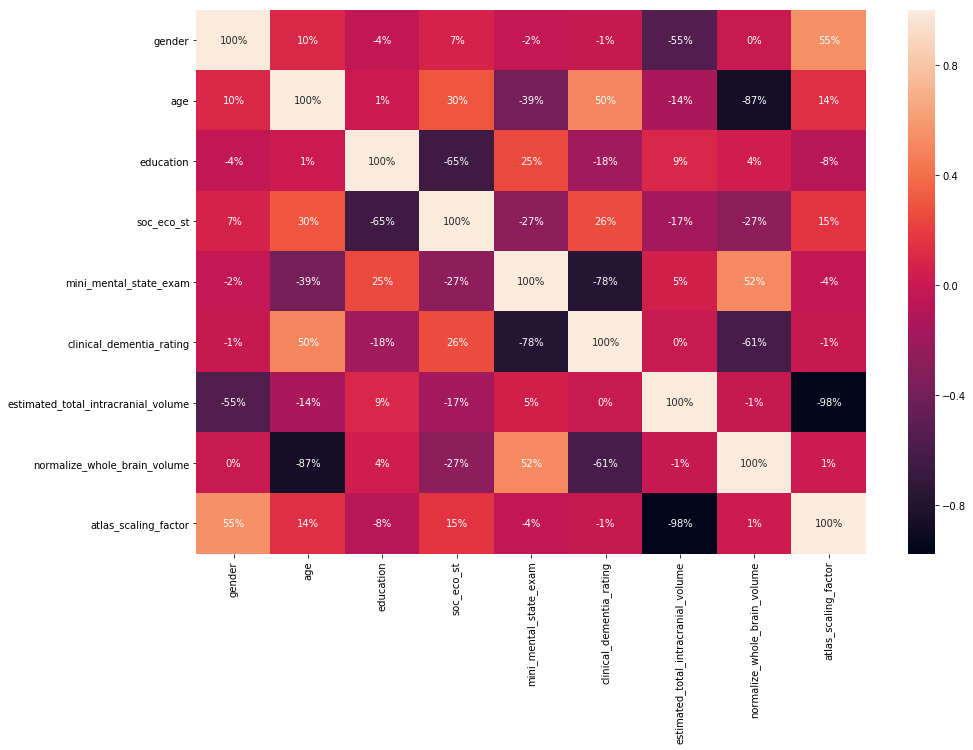

In [14]:
#visualize the correlation
plt.figure(figsize=(15,10))
sns.heatmap(data.iloc[:,0:10].corr(), annot=True,fmt=".0%")
plt.show()

**Elbow Method -> determining optimum 'k' value**

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

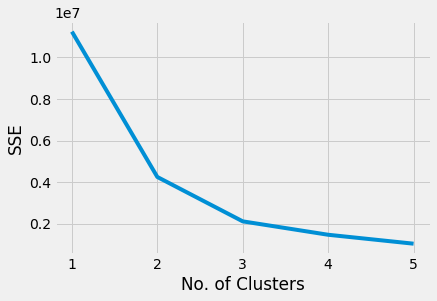

In [16]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}
sse = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 6), sse)
plt.xticks(range(1, 6))
plt.xlabel("No. of Clusters")
plt.ylabel("SSE")
#Note : Error Sum of Squares (SSE) is the sum of the squared differences between each observation and its group's mean.
plt.show()

In [17]:
# KMeans Clustering

kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=500,
random_state=42
)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=500, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [18]:
import seaborn as sns
from sklearn.model_selection import train_test_split
labels = kmeans.fit_predict(data)
labels = kmeans.labels_
pred = kmeans.predict(data)
labels

array([1, 1, 2, 2, 0, 1, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 0, 2, 1, 0, 2, 2,
       1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2,
       1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 0, 1,
       2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2,
       2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 0, 1, 0,
       2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2,
       2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 1, 0, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 0, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2,
       1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1,
       1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 0, 1,
       2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 2,
       2, 2, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0,

In [19]:
from numpy import unique
clusters = unique(labels)
clusters

array([0, 1, 2], dtype=int32)

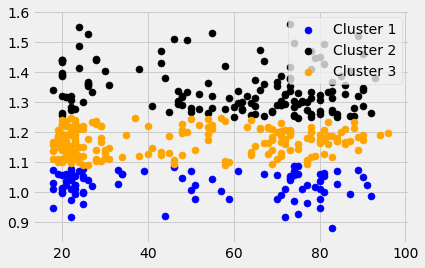

In [20]:
#Plotting the results

plt.scatter(data[labels == 0].iloc[:, 1:2], data[labels == 0].iloc[:, 8:9], s = 50, c = 'blue', label = 'Cluster 1')
plt.scatter(data[labels == 1].iloc[:, 1:2], data[labels == 1].iloc[:, 8:9], s = 50, c = 'black', label = 'Cluster 2')
plt.scatter(data[labels == 2].iloc[:, 1:2], data[labels == 2].iloc[:, 8:9], s = 50, c = 'orange', label = 'Cluster 3')

plt.legend(loc='upper right')
plt.show()

**EVALUATION METRICS**

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

silhoutteScore = silhouette_score(data,pred, metric='euclidean')
print('Silhoutte Score: %.4f' % silhoutteScore)

calinski_harabasz_score_ = calinski_harabasz_score(data, labels)
print('Calinski Harabasz Score: %.4f' % calinski_harabasz_score_)

davies_bouldin_score_ = davies_bouldin_score(data, labels)
print('Davies Bouldin Score: %.4f' % davies_bouldin_score_)

Silhoutte Score: 0.5147
Calinski Harabasz Score: 937.7044
Davies Bouldin Score: 0.6083
